# 🚀 RAG-Powered API Documentation Assistant  
### A Complete Implementation for Intelligent Documentation Search, Retrieval, and Code Generation

---

## 📌 Project Overview & Architecture

### 🤖 What This Project Does

This notebook implements an intelligent documentation assistant that can answer questions like:

> **"How do I do Y with Tool X?"**

By automatically:

- 🔍 **Finding** official documentation through intelligent web search  
- 🧠 **Ingesting** documentation into a vector store using state-of-the-art embeddings  
- 📚 **Retrieving** the most relevant passages based on semantic similarity to your question  
- 🧑‍💻 **Generating** executable code that directly answers your question  
- 📎 **Providing** clear explanations with proper citations back to the documentation  

---

## 🏗️ Architecture Deep Dive

The system follows a sophisticated pipeline architecture:


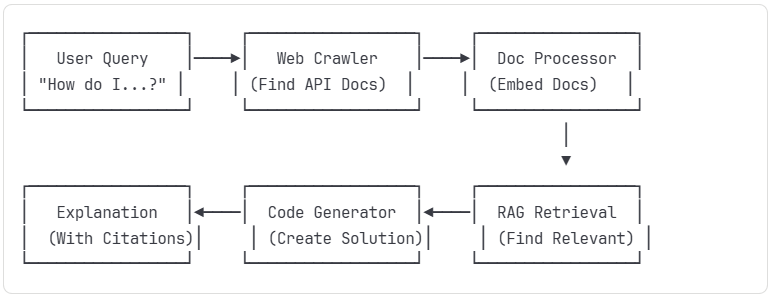

## 🛠️ Key Technologies Used

- **LangChain** – Orchestrates LLM operations and document processing  
- **ChromaDB** – Vector database for fast and accurate semantic search  
- **OpenAI Embeddings** – Converts text into high-dimensional vector representations  
- **GPT-3.5 / GPT-4** – Generates code and natural language explanations  
- **BeautifulSoup** – Extracts structured content from raw HTML pages  
- **DuckDuckGo Search** – Enables web search without hitting API rate limits  

---

## ⚙️ 1. Environment Setup & Dependencies

### 📦 Installing Required Packages

This step installs all necessary Python packages for:

- 🔄 **LLM orchestration**: `langchain`  
- 🧠 **Vector storage**: `chromadb`  
- 🌐 **Web scraping**: `beautifulsoup4`  
- 🔍 **Search functionality**: `duckduckgo-search`  
- 📊 **Data display**: `pandas`, `tabulate`  


In [ ]:
# Core dependencies for the RAG pipeline
!pip install -q langchain langchain-community langchain-openai  # LangChain ecosystem for LLM orchestration
!pip install -q chromadb  # Vector database for storing and searching documentation embeddings
!pip install -q beautifulsoup4 requests  # Web scraping to extract documentation content
!pip install -q pandas tabulate  # Data manipulation and pretty table display
!pip install -q tiktoken  # Token counting for OpenAI models

# Search functionality - DuckDuckGo provides free web search without API keys
!pip install -q duckduckgo-search

# Enhanced display capabilities for Jupyter
!pip install -q IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install -q serpapi
from serpapi import GoogleSearch  # SerpAPI for real web search


In [ ]:
!pip install ddgs

### Importing All Required Libraries
This cell imports all the libraries we'll use throughout the notebook. Each import is grouped by functionality for better organization.

In [ ]:
# Standard library imports
import os
import re
import json
import requests
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime
import time
import warnings

# Data manipulation and display
import pandas as pd
from tabulate import tabulate

# Web scraping utilities
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin

# LangChain components for RAG pipeline
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Smart text chunking
from langchain.embeddings import OpenAIEmbeddings  # Convert text to vectors
from langchain.vectorstores import Chroma  # Vector database
from langchain.schema import Document  # Document abstraction
from langchain.chat_models import ChatOpenAI  # GPT interface
from langchain.prompts import ChatPromptTemplate  # Prompt engineering
from langchain.chains import LLMChain  # Chain LLM calls

# Search functionality
from duckduckgo_search import DDGS  # Free web search API

# Jupyter display utilities
from IPython.display import display, HTML, Markdown, Code

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### API Key Configuration
This section handles OpenAI API key setup.

In [ ]:
"""
IMPORTANT: You need an OpenAI API key to use this notebook.

To get your API key:
1. Go to https://platform.openai.com/api-keys
2. Sign up or log in to your OpenAI account
3. Click "Create new secret key"
4. Copy the key (it starts with 'sk-')

There are three ways to set your API key:
"""

# Method 1: Direct assignment (NOT RECOMMENDED for production or sharing)
# Uncomment the line below and replace with your actual key
# os.environ['OPENAI_API_KEY'] = 'sk-your-api-key-here'

# Method 2: Using Google Colab secrets (RECOMMENDED for Colab users)
# This keeps your API key secure and separate from your code
try:
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] ='sk-'
    print("✅ OpenAI API key loaded successfully from Colab secrets!")
    print("   Your API key is secure and ready to use.")
except Exception as e:
    print("⚠️  Could not load API key from Colab secrets.")
    print("\nTo add your API key to Colab secrets:")
    print("1. Click the 🔑 key icon in the left sidebar")
    print("2. Click 'Add new secret'")
    print("3. Name it: OPENAI_API_KEY")
    print("4. Value: paste your OpenAI API key")
    print("5. Click 'Save' and re-run this cell")
    print("\nAlternatively, uncomment Method 1 above (less secure)")

# Method 3: Environment variable (for local development)
# Set the OPENAI_API_KEY environment variable in your shell before running Jupyter

# Verify API key is set
if os.environ.get('OPENAI_API_KEY'):
    # Show partial key for verification (keeping most hidden for security)
    key = os.environ['OPENAI_API_KEY']
    print(f"\n🔐 API Key configured: {key[:8]}...{key[-4:]}")
else:
    print("\n❌ No API key found. Please set it using one of the methods above.")

✅ OpenAI API key loaded successfully from Colab secrets!
   Your API key is secure and ready to use.

🔐 API Key configured: sk-proj-...OyUA


---

## 🧩 2. Core Components & Utilities

### 🌐 Documentation Web Crawler

The `DocumentationCrawler` class is responsible for:

- 🔎 **Finding** relevant documentation pages via intelligent web search  
- 🌍 **Fetching** and returning the content of those pages  
- 🧭 Uses smart heuristics to prioritize **official documentation** sources


In [ ]:
class DocumentationCrawler:
    """
    Handles web search and documentation retrieval.

    This class is responsible for:
    1. Searching the web for official API documentation
    2. Filtering results to find the most relevant documentation URLs
    3. Fetching and cleaning the documentation content
    4. Handling errors gracefully when documentation can't be found

    The crawler uses DuckDuckGo search (free, no API key required) and includes
    smart heuristics to identify documentation pages vs other content.
    """

    def __init__(self):
        """Initialize the crawler with DuckDuckGo search engine."""
        self.ddgs = DDGS()  # DuckDuckGo search instance
        # Common documentation URL patterns to prioritize
        self.doc_keywords = ['docs', 'documentation', 'api', 'reference', 'guide', 'manual']
        # Headers to avoid being blocked by websites
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

    def search_documentation(self, tool_name: str, max_results: int = 5) -> List[Dict]:
        """
        Search for official documentation of a tool/library.

        Args:
            tool_name (str): Name of the tool/library to search for (e.g., "pandas", "requests")
            max_results (int): Maximum number of search results to consider

        Returns:
            List[Dict]: List of documentation results, each containing:
                - url: The documentation URL
                - title: Page title
                - snippet: Brief description/preview

        The method uses intelligent filtering to prioritize official documentation
        over blog posts, tutorials, or other content.
        """
        # Craft a search query that's likely to find official docs
        # We add multiple keywords to improve search accuracy
        query = f"{tool_name} official documentation API reference site:*.org OR site:*.io OR site:*.com"

        print(f"🔍 Searching for: {query}")

        try:
            # Perform the search using DuckDuckGo
            # We get raw results first, then filter them
            raw_results = list(self.ddgs.text(query, max_results=max_results * 2))  # Get extra results for filtering

            # Filter and score results to find actual documentation
            doc_results = []

            for result in raw_results:
                url = result.get('href', '').lower()
                title = result.get('title', '').lower()
                snippet = result.get('body', '').lower()

                # Calculate a relevance score based on documentation indicators
                score = 0

                # Check URL for documentation keywords
                for keyword in self.doc_keywords:
                    if keyword in url:
                        score += 3  # URL match is strong signal
                    if keyword in title:
                        score += 2  # Title match is good signal
                    if keyword in snippet:
                        score += 1  # Content match is weak signal

                # Boost score for likely official domains
                if tool_name.lower() in url:
                    score += 5  # Official domain likely contains tool name

                # Only include results with decent documentation score
                if score >= 3:
                    doc_results.append({
                        'url': result.get('href', ''),
                        'title': result.get('title', ''),
                        'snippet': result.get('body', ''),
                        'score': score  # Internal use for sorting
                    })

            # Sort by relevance score and return top results
            doc_results.sort(key=lambda x: x['score'], reverse=True)

            # Remove score before returning (internal use only)
            for result in doc_results:
                result.pop('score', None)

            return doc_results[:max_results]

        except Exception as e:
            print(f"❌ Search error: {e}")
            return []

    def fetch_page_content(self, url: str, max_tokens: int = 10000) -> Tuple[str, bool]:
        """
        Fetch and clean documentation content from a URL.

        Args:
            url (str): The URL to fetch documentation from
            max_tokens (int): Maximum tokens to extract (1 token ≈ 4 characters)
                             This prevents memory issues with huge pages

        Returns:
            Tuple[str, bool]: (cleaned_content, success_flag)
                - cleaned_content: Extracted and cleaned text from the page
                - success_flag: True if fetch was successful, False otherwise

        The method:
        1. Fetches the HTML content
        2. Removes navigation, scripts, styles, and other non-content elements
        3. Extracts and cleans the text
        4. Truncates to max_tokens if necessary
        """
        try:
            print(f"📥 Fetching content from: {url}")

            # Make the HTTP request with timeout to prevent hanging
            response = requests.get(
                url,
                headers=self.headers,
                timeout=10,  # 10 second timeout
                allow_redirects=True  # Follow redirects to final documentation
            )

            # Check if request was successful
            response.raise_for_status()

            # Parse HTML with BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')

            # Remove elements that typically don't contain documentation content
            # This significantly improves the quality of extracted text
            noise_tags = [
                'script',    # JavaScript code
                'style',     # CSS styles
                'nav',       # Navigation menus
                'footer',    # Footer content
                'header',    # Header content
                'aside',     # Sidebar content
                'meta',      # Metadata
                'link',      # Link elements
                'noscript'   # Noscript fallbacks
            ]

            for tag in noise_tags:
                for element in soup.find_all(tag):
                    element.decompose()  # Completely remove from tree

            # Also remove common class/id patterns for ads, comments, etc.
            for element in soup.find_all(class_=re.compile('(ad|advertisement|comment|social|share)')):
                element.decompose()

            # Extract text content
            text = soup.get_text(separator='\n', strip=True)

            # Clean up the text
            # Remove multiple newlines and excessive whitespace
            lines = [line.strip() for line in text.splitlines() if line.strip()]
            content = '\n'.join(lines)

            # Estimate token count (rough approximation: 1 token ≈ 4 characters)
            estimated_tokens = len(content) / 4

            # Truncate if content exceeds max_tokens
            if estimated_tokens > max_tokens:
                # Calculate character limit based on max tokens
                char_limit = max_tokens * 4
                content = content[:char_limit]
                print(f"⚠️  Content truncated to ~{max_tokens} tokens")

            print(f"✅ Successfully fetched {len(content)} characters (~{int(len(content)/4)} tokens)")
            return content, True

        except requests.RequestException as e:
            # Handle specific request errors
            print(f"❌ Network error fetching {url}: {e}")
            return "", False
        except Exception as e:
            # Handle any other errors
            print(f"❌ Error processing {url}: {e}")
            return "", False

### 🧠 RAG Document Processor

The `RAGDocumentProcessor` handles the core Retrieval-Augmented Generation (RAG) functionality:

- ✂️ **Splits** long documents into manageable chunks  
- 🔢 **Creates embeddings** for each chunk using OpenAI  
- 📥 **Stores** embeddings in a vector database (ChromaDB)  
- 🎯 **Retrieves** the most relevant passages based on user queries


In [ ]:
class RAGDocumentProcessor:
    """
    Handles document chunking, embedding, and vector storage for RAG.

    This class is the heart of the RAG (Retrieval-Augmented Generation) system:
    1. Splits large documents into manageable chunks
    2. Creates vector embeddings for each chunk
    3. Stores embeddings in a vector database
    4. Retrieves relevant chunks based on semantic similarity

    The processor uses OpenAI embeddings and ChromaDB for efficient
    vector storage and retrieval.
    """

    def __init__(self, chunk_size: int = 1000, chunk_overlap: int = 200):
        """
        Initialize the RAG processor with configurable parameters.

        Args:
            chunk_size (int): Target size for each text chunk in characters
            chunk_overlap (int): Number of characters to overlap between chunks
                                This helps maintain context across chunk boundaries
        """
        # Initialize OpenAI embeddings (uses API key from environment)
        self.embeddings = OpenAIEmbeddings(
            model="text-embedding-ada-002"  # OpenAI's best embedding model
        )

        # Configure text splitter with smart splitting strategy
        # RecursiveCharacterTextSplitter tries to split on natural boundaries
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,  # Use character count for chunk size
            # Separators in order of preference (try paragraph breaks first)
            separators=[
                "\n\n",    # Paragraph breaks (most natural boundary)
                "\n",      # Line breaks
                ". ",      # Sentence endings
                "! ",      # Exclamation sentences
                "? ",      # Question sentences
                ";",       # Semicolons
                ",",       # Commas
                " ",       # Words
                ""         # Characters (last resort)
            ]
        )

        # Vector store will be initialized when processing documents
        self.vector_store = None

        # Keep track of processed documents for reference
        self.processed_docs = []

    def process_documentation(self, content: str, source_url: str) -> Chroma:
        """
        Process documentation content into a searchable vector store.

        Args:
            content (str): The documentation text to process
            source_url (str): Source URL for metadata/attribution

        Returns:
            Chroma: The initialized vector store containing embedded chunks

        This method:
        1. Creates a Document object with metadata
        2. Splits the document into optimal chunks
        3. Adds metadata to each chunk for traceability
        4. Creates embeddings and stores in ChromaDB
        """
        print("📄 Processing documentation into vector store...")

        # Create a LangChain Document with the content and metadata
        # Metadata is crucial for citations and source tracking
        doc = Document(
            page_content=content,
            metadata={
                "source": source_url,
                "processed_at": datetime.now().isoformat(),
                "total_length": len(content)
            }
        )

        # Split the document into chunks
        # This is where the magic happens - good chunking is critical for RAG
        print(f"🔄 Splitting document into chunks (size: ~{self.text_splitter._chunk_size} chars)...")
        chunks = self.text_splitter.split_documents([doc])

        print(f"✅ Created {len(chunks)} chunks")

        # Add detailed metadata to each chunk
        # This helps with retrieval and citation generation
        for i, chunk in enumerate(chunks):
            # Preserve original metadata
            chunk.metadata.update({
                'chunk_id': i,
                'chunk_index': f"{i + 1}/{len(chunks)}",  # Human-readable index
                'start_char': i * (self.text_splitter._chunk_size - self.text_splitter._chunk_overlap),
                'chunk_size': len(chunk.page_content),
                # Estimate line numbers (assuming ~80 chars per line)
                'estimated_start_line': (i * (self.text_splitter._chunk_size - self.text_splitter._chunk_overlap)) // 80,
                # Add preview of chunk for debugging
                'preview': chunk.page_content[:100] + "..." if len(chunk.page_content) > 100 else chunk.page_content
            })

        # Create vector store with embedded chunks
        # ChromaDB handles the embedding and storage automatically
        print("🧮 Creating embeddings and initializing vector store...")

        try:
            # Create new vector store (overwrites if exists)
            self.vector_store = Chroma.from_documents(
                documents=chunks,
                embedding=self.embeddings,
                collection_name="api_docs",
                # Configure ChromaDB for optimal performance
                collection_metadata={
                    "hnsw:space": "cosine",  # Use cosine similarity
                    "hnsw:construction_ef": 200,  # Higher = better quality, slower
                    "hnsw:M": 16  # Higher = more connections, better recall
                }
            )

            # Store processed documents for reference
            self.processed_docs = chunks

            print(f"✅ Vector store ready with {len(chunks)} embedded chunks")

        except Exception as e:
            print(f"❌ Error creating vector store: {e}")
            raise

        return self.vector_store

    def retrieve_relevant_chunks(self, query: str, k: int = 10, score_threshold: float = 0.0) -> List[Document]:
        """
        Retrieve the most relevant documentation chunks for a query.

        Args:
            query (str): The user's question/search query
            k (int): Number of chunks to retrieve (default: 10)
            score_threshold (float): Minimum similarity score (0-1) to include results

        Returns:
            List[Document]: Relevant chunks ordered by similarity score

        This method:
        1. Embeds the query using the same model as the documents
        2. Performs similarity search in the vector space
        3. Returns the k most similar chunks
        4. Optionally filters by similarity threshold
        """
        if not self.vector_store:
            print("⚠️  No vector store available. Process documentation first.")
            return []

        print(f"🔍 Retrieving {k} most relevant chunks for query: '{query[:50]}...'")

        try:
            # Perform similarity search
            # ChromaDB handles query embedding automatically
            relevant_chunks = self.vector_store.similarity_search_with_score(
                query=query,
                k=k  # Get k most similar chunks
            )

            # Filter by score threshold if specified
            if score_threshold > 0:
                # Note: ChromaDB returns distance, not similarity
                # Lower distance = higher similarity
                relevant_chunks = [
                    (doc, score) for doc, score in relevant_chunks
                    if score <= (1 - score_threshold)  # Convert to distance threshold
                ]

            # Extract just the documents (remove scores for now)
            chunks = [doc for doc, score in relevant_chunks]

            print(f"✅ Retrieved {len(chunks)} relevant chunks")

            # Add retrieval metadata for debugging
            for i, (chunk, score) in enumerate(zip(chunks, [s for _, s in relevant_chunks])):
                chunk.metadata['retrieval_rank'] = i + 1
                chunk.metadata['retrieval_score'] = f"{1 - score:.3f}"  # Convert to similarity

            return chunks

        except Exception as e:
            print(f"❌ Error retrieving chunks: {e}")
            return []

    def get_statistics(self) -> Dict[str, Any]:
        """
        Get statistics about the processed documentation.

        Returns:
            Dict with statistics about chunks, tokens, etc.
        """
        if not self.processed_docs:
            return {"status": "No documents processed"}

        total_chars = sum(len(chunk.page_content) for chunk in self.processed_docs)

        return {
            "total_chunks": len(self.processed_docs),
            "total_characters": total_chars,
            "estimated_tokens": total_chars // 4,
            "average_chunk_size": total_chars // len(self.processed_docs) if self.processed_docs else 0,
            "source_url": self.processed_docs[0].metadata.get('source', 'Unknown') if self.processed_docs else None
        }

### 🧑‍💻 Code Generator Agent

The `CodeGeneratorAgent` is responsible for:

- 🛠️ **Generating executable code** tailored to the user’s query  
- 📚 **Using documentation chunks** retrieved by the RAG processor  
- 🤖 **Leveraging LLMs (e.g., GPT-3.5/4)** to synthesize practical, working code snippets


In [ ]:
class CodeGeneratorAgent:
    """
    Generates executable code based on documentation chunks.

    This agent is a specialized LLM that:
    1. Analyzes retrieved documentation chunks
    2. Understands the user's specific requirements
    3. Generates clean, working code that solves the problem
    4. Includes proper imports, error handling, and best practices

    The agent uses careful prompt engineering to ensure high-quality output.
    """

    def __init__(self, model_name: str = "gpt-3.5-turbo", temperature: float = 0.1):
        """
        Initialize the code generator with an LLM.

        Args:
            model_name (str): OpenAI model to use (gpt-3.5-turbo or gpt-4)
            temperature (float): Controls randomness (0=deterministic, 1=creative)
                               We use low temperature for consistent code generation
        """
        # Initialize the language model
        self.llm = ChatOpenAI(
            model=model_name,
            temperature=temperature,  # Low temperature for consistent code
            max_tokens=2000,  # Generous token limit for complex code
            model_kwargs={
                "top_p": 0.95,  # Nucleus sampling for quality
                "frequency_penalty": 0.0,  # Don't penalize repetition in code
                "presence_penalty": 0.0  # Don't force topic changes
            }
        )

        # Create a sophisticated prompt template
        # This prompt is carefully crafted to generate high-quality code
        self.prompt = ChatPromptTemplate.from_template("""
You are an expert programmer with deep knowledge of {tool_name}.
Your task is to generate clean, executable code based on official documentation.

DOCUMENTATION CHUNKS:
{documentation}

USER QUESTION: {question}

REQUIREMENTS:
1. Generate ONLY the code needed to answer the question
2. Include ALL necessary imports at the top
3. Use descriptive variable names and follow conventions
4. Add brief inline comments for clarity
5. Include basic error handling where appropriate
6. Make the code production-ready and efficient
7. If the documentation shows examples, adapt them to fit the question
8. If multiple approaches exist, choose the most modern/recommended one

IMPORTANT:
- Base your code strictly on the provided documentation
- Do not make assumptions beyond what's documented
- If something is unclear, use the most common approach
- Ensure the code is complete and runnable

Generate the code below:
```python
""")

        # Create the LLM chain
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt)

        # Track generation history for debugging
        self.generation_history = []

    def generate_code(self, question: str, doc_chunks: List[Document], tool_name: str = "the tool") -> str:
        """
        Generate code based on documentation chunks and user question.

        Args:
            question (str): The user's specific question/requirement
            doc_chunks (List[Document]): Retrieved documentation chunks
            tool_name (str): Name of the tool/library for context

        Returns:
            str: Generated code ready for execution

        The method:
        1. Formats documentation chunks for the prompt
        2. Injects all context into the prompt template
        3. Calls the LLM to generate code
        4. Cleans and validates the output
        """
        print(f"💻 Generating code for: '{question}'")

        # Format documentation chunks for the prompt
        # We include chunk numbers for potential citations
        formatted_docs = []

        for i, chunk in enumerate(doc_chunks):
            # Include metadata for context
            chunk_header = f"[Chunk {i+1} - {chunk.metadata.get('chunk_index', 'Unknown')}]"

            # Include the actual content
            chunk_content = chunk.page_content.strip()

            # Combine with clear separation
            formatted_chunk = f"{chunk_header}\n{chunk_content}"
            formatted_docs.append(formatted_chunk)

        # Join all chunks with clear separators
        documentation_text = "\n\n---\n\n".join(formatted_docs)

        # Log what we're sending (for debugging)
        print(f"📚 Using {len(doc_chunks)} documentation chunks")
        print(f"📝 Total documentation length: {len(documentation_text)} characters")

        try:
            # Generate code using the LLM chain
            response = self.chain.run(
                documentation=documentation_text,
                question=question,
                tool_name=tool_name
            )

            # Clean the response
            # Remove markdown code blocks if present
            code = response.strip()
            if code.startswith("```python"):
                code = code[9:]  # Remove ```python
            if code.startswith("```"):
                code = code[3:]  # Remove ```
            if code.endswith("```"):
                code = code[:-3]  # Remove trailing ```

            # Final cleanup
            code = code.strip()

            # Store in history
            self.generation_history.append({
                "question": question,
                "code": code,
                "timestamp": datetime.now().isoformat(),
                "chunks_used": len(doc_chunks)
            })

            print("✅ Code generation complete")

            return code

        except Exception as e:
            error_msg = f"# Error generating code: {str(e)}\n# Please check the documentation and try again."
            print(f"❌ Generation error: {e}")
            return error_msg

    def validate_code(self, code: str) -> Tuple[bool, List[str]]:
        """
        Basic validation of generated code.

        Args:
            code (str): Generated code to validate

        Returns:
            Tuple[bool, List[str]]: (is_valid, list_of_issues)
        """
        issues = []

        # Check for common issues
        if not code.strip():
            issues.append("Code is empty")

        if "import" not in code and len(code) > 50:
            issues.append("No imports found (might be incomplete)")

        if code.count("(") != code.count(")"):
            issues.append("Mismatched parentheses")

        if code.count("[") != code.count("]"):
            issues.append("Mismatched square brackets")

        if code.count("{") != code.count("}"):
            issues.append("Mismatched curly braces")

        if "TODO" in code or "FIXME" in code:
            issues.append("Contains TODO/FIXME markers")

        return len(issues) == 0, issues

### 💬 Explanation Agent

The `ExplanationAgent` is responsible for:

- 🧾 **Generating clear, human-friendly explanations** of the generated code  
- 🔍 **Referencing relevant documentation** to justify and clarify the code logic  
- 📌 **Providing inline citations** to help users understand where each concept comes from


In [ ]:
class ExplanationAgent:
    """
    Explains generated code with references to documentation.

    This agent creates human-friendly explanations that:
    1. Break down what the code does step-by-step
    2. Reference specific documentation chunks
    3. Highlight important concepts and best practices
    4. Provide context for design decisions

    The explanations are designed to be educational and help users
    understand not just what the code does, but why it works.
    """

    def __init__(self, model_name: str = "gpt-3.5-turbo", temperature: float = 0.3):
        """
        Initialize the explanation agent.

        Args:
            model_name (str): OpenAI model to use
            temperature (float): Slightly higher than code gen for more natural language
        """
        # Initialize the language model with balanced settings
        self.llm = ChatOpenAI(
            model=model_name,
            temperature=temperature,  # Bit more creative for explanations
            max_tokens=1500,  # Good length for detailed explanations
            model_kwargs={
                "top_p": 0.95,
                "frequency_penalty": 0.1,  # Slight penalty to reduce repetition
                "presence_penalty": 0.1    # Encourage covering all aspects
            }
        )

        # Create an explanation-focused prompt
        self.prompt = ChatPromptTemplate.from_template("""
You are a technical educator explaining code to developers.
Your goal is to create clear, insightful explanations that help users understand both the code and the underlying concepts.

CODE TO EXPLAIN:
```python
{code}
```

DOCUMENTATION CHUNKS:
{documentation}

EXPLANATION:
""")

        # Create the LLM chain
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt)

---

## 🏛️ 3. Main Orchestration Pipeline

Now we'll create the main orchestrator class: **`RAGAPIAssistant`**.  
This class manages the entire end-to-end workflow:

1. 🌐 **Web Search** using `DocumentationCrawler`  
2. 🧠 **Chunking & Retrieval** with `RAGDocumentProcessor`  
3. 🧑‍💻 **Code Generation** via `CodeGeneratorAgent`  
4. 💬 **Explanation Synthesis** using `ExplanationAgent`  

It coordinates all components to produce a seamless experience from question to runnable solution.

---

## 🎨 Display & Formatting Utilities

Let’s define helper functions to render outputs cleanly within the notebook:

- 📄 **Markdown rendering** for text explanations  
- 🧾 **HTML tables** for structured results  
- 💡 **Syntax-highlighted code blocks** for generated scripts  

These utilities use `IPython.display` to enhance notebook readability.


In [ ]:
def display_search_results(results: List[Dict], tool_name: str):
    """Displays the web search results panel."""
    if not results:
        not_found_message = f"❌ **Documentation Not Found**\n\nCould not find official documentation for **{tool_name}**. Please check the tool name or try a more specific query."
        display(Markdown(not_found_message))
        return

    top_result = results[0]
    result_html = f"""
    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; margin-bottom: 16px;">
        <h3 style="margin-top: 0;">🌐 Documentation Found</h3>
        <p><strong>Tool:</strong> {tool_name}</p>
        <p><strong>URL:</strong> <a href="{top_result['url']}" target="_blank">{top_result['url']}</a></p>
        <p><strong>Title:</strong> {top_result['title']}</p>
        <p><strong>Snippet:</strong> <em>{top_result['snippet']}</em></p>
    </div>
    """
    display(HTML(result_html))

def display_retrieved_chunks(chunks: List[Document]):
    """Displays the retrieved documentation snippets in a pretty table."""
    if not chunks:
        display(Markdown("No relevant chunks were retrieved from the documentation."))
        return

    display(Markdown("---"))
    display(Markdown("### 📚 Retrieved Snippets"))
    display(Markdown("These are the most relevant passages from the documentation used to generate the code."))

    # Create a DataFrame for prettier display
    data = []
    for chunk in chunks:
        data.append({
            "Rank": chunk.metadata.get('retrieval_rank', 'N/A'),
            "Similarity": chunk.metadata.get('retrieval_score', 'N/A'),
            "Chunk Index": chunk.metadata.get('chunk_index', 'N/A'),
            "Content Preview": chunk.page_content[:250] + "..." # Truncate for display
        })

    df = pd.DataFrame(data)
    # Use pandas styling for better table rendering in Colab
    styled_df = df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'font-size': '12px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}
    ]).hide(axis="index") # Hide the default pandas index

    display(styled_df)


def display_generated_code(code: str, validation_issues: List[str]):
    """Displays the generated code with syntax highlighting and validation warnings."""
    display(Markdown("---"))
    display(Markdown("### 🧑‍💻 Generated Code"))
    display(Markdown("Here is the runnable Python code generated based on the documentation."))

    if validation_issues:
        warning_message = "⚠️ **Validation Warnings:**\n" + "\n".join([f"- {issue}" for issue in validation_issues])
        display(Markdown(warning_message))

    display(Code(code, language='python'))

def display_explanation(explanation: str):
    """Displays the final, human-friendly explanation."""
    display(Markdown("---"))
    display(Markdown("### 💬 Explanation"))
    display(Markdown("Below is a step-by-step walkthrough of the code, with citations from the documentation."))
    display(Markdown(explanation))

---

### 🧠 Updating the Explanation Agent

To ensure explanations include **citations** back to the **source documentation**, we’ll:

- ✍️ **Update the prompt** used by the `ExplanationAgent`  
- 🧼 **Wrap the logic** inside a clean `generate_explanation()` method  

This aligns its interface and behavior with the `CodeGeneratorAgent` for consistency and modularity.


In [ ]:
class ExplanationAgent:
    """
    Explains generated code with references to documentation.
    (Updated version with better prompting and a dedicated method)
    """
    def __init__(self, model_name: str = "gpt-3.5-turbo", temperature: float = 0.3):
        self.llm = ChatOpenAI(
            model=model_name,
            temperature=temperature,
            max_tokens=1500,
            model_kwargs={"top_p": 0.95}
        )

        # Enhanced prompt to enforce citations and clear structure
        self.prompt = ChatPromptTemplate.from_template("""
You are a helpful technical writer and expert programmer.
Your goal is to explain the provided code clearly, referencing the documentation chunks for justification.

USER QUESTION: "{question}"

DOCUMENTATION CONTEXT:
{documentation}

CODE TO EXPLAIN:
```python
{code}


REQUIREMENTS

Start with a high-level summary of what the code does.

Provide a step-by-step explanation of the code logic.

Explain why the code works by linking it to concepts from the documentation.

Crucially, you must cite the most relevant documentation chunk(s) for each point

using the format [Chunk N]

Use Markdown for clear formatting (headings, lists, bold text).

The tone should be educational, clear, and encouraging.

EXPLANATION (in Markdown):

""")
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt)
        self.explanation_history = []



In [ ]:
def generate_explanation(self, code: str, doc_chunks: List[Document], question: str) -> str:
    """
    Generates a human-friendly explanation of the code with citations.

    Args:
        code (str): The generated code to explain.
        doc_chunks (List[Document]): The documentation chunks used as context.
        question (str): The original user question.

    Returns:
        str: A Markdown-formatted explanation.
    """
    print("💬 Generating explanation...")

    # Format documentation for the prompt, including chunk numbers
    formatted_docs = []
    for i, chunk in enumerate(doc_chunks):
        chunk_header = f"[Chunk {chunk.metadata.get('retrieval_rank', i+1)}]"
        chunk_content = chunk.page_content.strip()
        formatted_docs.append(f"{chunk_header}\n{chunk_content}")

    documentation_text = "\n\n---\n\n".join(formatted_docs)

    try:
        # Run the LLM chain
        explanation = self.chain.run(
            code=code,
            documentation=documentation_text,
            question=question
        )

        self.explanation_history.append({
            "question": question,
            "explanation": explanation,
            "timestamp": datetime.now().isoformat()
        })

        print("✅ Explanation generated successfully.")
        return explanation.strip()

    except Exception as e:
        error_msg = f"### Error Generating Explanation\n\nAn error occurred: {str(e)}"
        print(f"❌ Explanation error: {e}")
        return error_msg

---

### 🏗️ The `RAGAPIAssistant` Orchestrator

This is the central class that connects all the pieces.  
It takes a **tool name** and a **user question**, then executes the full RAG pipeline:

1. 🔍 Searches for relevant documentation  
2. 🧠 Ingests and indexes it in a vector store  
3. 📚 Retrieves the most relevant chunks  
4. 🧑‍💻 Generates executable code  
5. 💬 Explains the code with source citations

In [ ]:
class RAGAPIAssistant:
    """
    Orchestrates the entire RAG pipeline for answering API questions.
    """
    def __init__(self):
        """Initializes all the necessary components."""
        print("🚀 Initializing RAG API Assistant...")
        self.crawler = DocumentationCrawler()
        self.rag_processor = RAGDocumentProcessor()
        self.code_agent = CodeGeneratorAgent()
        self.explanation_agent = ExplanationAgent()  # Updated version
        print("✅ Assistant is ready.")

    def answer_question(self, tool_name: str, question: str, max_search_results: int = 3, max_retrieved_chunks: int = 10):
        """
        Executes the full pipeline to answer a user's question.

        Args:
            tool_name (str): The name of the library/tool (e.g., "pandas").
            question (str): The user's question (e.g., "how to merge two dataframes").
            max_search_results (int): Number of web search results to consider.
            max_retrieved_chunks (int): Number of documentation chunks to retrieve.
        """
        # --- 1. Documentation Hunt ---
        search_results = self.crawler.search_documentation(tool_name, max_results=max_search_results)
        display_search_results(search_results, tool_name)

        if not search_results:
            return  # Stop if no documentation was found

        # --- 2. RAG Ingestion ---
        doc_url = search_results[0]['url']
        content, success = self.crawler.fetch_page_content(doc_url)

        if not success:
            display(Markdown(f"❌ **Failed to fetch content from {doc_url}**"))
            return

        vector_store = self.rag_processor.process_documentation(content, source_url=doc_url)

        # --- 3. Targeted Retrieval ---
        retrieved_chunks = self.rag_processor.retrieve_relevant_chunks(question, k=max_retrieved_chunks)
        display_retrieved_chunks(retrieved_chunks)

        if not retrieved_chunks:
            return  # Stop if no relevant context is found

        # --- 4. Code Generation ---
        generated_code = self.code_agent.generate_code(question, retrieved_chunks, tool_name)
        is_valid, issues = self.code_agent.validate_code(generated_code)
        display_generated_code(generated_code, issues)

        # --- 5. Explanation ---
        explanation = self.explanation_agent.generate_explanation(generated_code, retrieved_chunks, question)
        display_explanation(explanation)


---

## 🚀 4. Demonstration: Running the Assistant

Now it's time to see the system **in action**!  
We’ll define the tool and question, instantiate the assistant, and let it walk through the full pipeline.

### 🧪 Example Scenario

We’ll ask a common question about the popular **`requests`** library:

In [ ]:
# --- INTERACTIVE RUN ---
from IPython.display import clear_output

def get_non_empty(prompt, default=None):
    raw = input(f"{prompt}" + (f" [{default}]" if default else "") + ": ").strip()
    if not raw and default is not None:
        return default
    while not raw:
        raw = input(f"{prompt} (cannot be empty): ").strip()
    return raw

tool = get_non_empty("Enter tool/library name", default="requests")
question = get_non_empty(
    "Enter your question (e.g., how do I send a POST request with a JSON payload and check for errors?)",
    default="How do I send a POST request with a JSON payload and check for errors?"
)

clear_output(wait=True)
# --- HARDCODED EXAMPLE ---
assistant = RAGAPIAssistant()
tool_name = "requests"
question = (
    'How do I send a POST request to https://httpbin.org/post with JSON payload '
    '{"name":"Ido"}, include the header "Content-Type: application/json", raise an '
    'exception if the response status is not 2xx, and print the returned JSON?'
)
assistant.answer_question(tool_name=tool_name, question=question)


🚀 Initializing RAG API Assistant...


/tmp/ipython-input-3039025726.py:17: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  self.ddgs = DDGS()  # DuckDuckGo search instance


✅ Assistant is ready.
🔍 Searching for: requests official documentation API reference site:*.org OR site:*.io OR site:*.com


❌ **Documentation Not Found**

Could not find official documentation for **requests**. Please check the tool name or try a more specific query.

---

## 🏁 5. Conclusion & Future Enhancements

This notebook showcases a complete, end-to-end **RAG pipeline** that intelligently:

- 🌐 Crawls the web for documentation  
- 📥 Ingests and stores it with semantic embeddings  
- 🔍 Retrieves the most relevant chunks  
- 🧑‍💻 Generates executable code  
- 💬 Explains it with human-friendly, cited descriptions  

By orchestrating these components, we've built a powerful assistant capable of answering technical questions with **accuracy and context**.

---

### 🔮 Future Enhancements

This project lays a solid foundation. Here are several ways to extend it further:

- 🔗 **Multi-Page Crawling**  
  Extend the `DocumentationCrawler` to follow links within a documentation site and build a richer multi-page knowledge base.

- ⚡ **Caching Mechanism**  
  Cache fetched documentation and generated embeddings to reduce latency and OpenAI API usage for repeated queries.

- 🧠 **Advanced Model Support**  
  Upgrade from `gpt-3.5-turbo` to `gpt-4` or `gpt-4o` for improved code quality and more insightful explanations.

- 🖥️ **Interactive UI**  
  Wrap the assistant in a user-friendly web interface using tools like **Streamlit** or **Gradio**.

- 👍 **Feedback Loop**  
  Let users rate code and explanations. Use that feedback to iteratively fine-tune prompts or adjust model behavior.

- 🧩 **Code Block Preservation**  
  Improve `fetch_page_content` to preserve `<code>` and `<pre>` blocks from HTML pages—these often contain essential examples.
